#**Imports**#

In [ ]:
#to make SIFT_create() working
!pip install opencv-python-headless

In [1]:
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import cv2
import time
from PIL import Image

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/'ImageProcessing_Assignment.zip (Unzipped Files)'/assignment/

/content/drive/MyDrive/ImageProcessing_Assignment.zip (Unzipped Files)/assignment


In [5]:
from exGenerator import *
matricola = '1937430'
ex10(matricola)

Features Extractor:
 Harris


#**Auxiliary functions**#


In [6]:
#get path to the Dataset
def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(path +'/'+ folder):
            images.append(path+'/' + folder  + '/'+  file)

    if(train is True):
        np.random.shuffle(images)
    
    return images

In [18]:
#get Descriptors for the SIFT
def getDescriptorsSift(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

#get Descriptors for the BRISK - the 3rd method used
def getDescriptorsBrisk(brisk, img):
    kp, des = brisk.detectAndCompute(img, None)
    return des

#get Features (features are the corners and they are used directly) for the Harris
def getCorners(img):
    #find Harris corners
    #Hyper-parameters suggested by Open-CV tutorial
    img = np.float32(img)
    dst = cv2.cornerHarris(img, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)
    ret, dst = cv2.threshold(dst, 0.01*dst.max(), 255, 0)
    dst = np.uint8(dst)

    #find centroids
    #to apply cv2.cornerSubPix()
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

    #define the criteria to stop and refine the corners
    #to find the corners with maximum accuracy
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(img, np.float32(centroids), (5,5),(-1,-1), criteria)

    return centroids, corners

#automatically converts to grayscale
def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img, (150,150))

#no need to modify for the BRISK and Harris
def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 
    return descriptors

In [8]:
#sklearn K-means
def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

#shapes are fine-tuned correspondingly to the method to be applied
def extractFeatures(kmeans, descriptor_list, image_count, no_clusters, method):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            if method == 'sift':
                feature = feature.reshape(1, 128)
            elif method == 'harris':
                feature = feature.reshape(1, 2)
            else:
                feature = feature.reshape(1, 64)
          
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    class_weight = {
        0: (807 / (7 * 140)),
        1: (807 / (7 * 140)),
        2: (807 / (7 * 133)),
        3: (807 / (7 * 70)),
        4: (807 / (7 * 42)),
        5: (807 / (7 * 140)),
        6: (807 / (7 * 142)) 
    }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
    svm.fit(features, train_labels)
    return svm

def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["city", "face", "green", "house_building", "house_indoor", "office", "sea"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))


#**Train function**#

In [38]:
def trainModel(path, no_clusters, kernel, method):
    start_time = time.time()
    print('Training starting time: ', time.asctime(time.localtime(start_time)))
    images = getFiles(True, path)
    print("Train images path detected.")

    #Initializers for the SIFT and BRISK
    if method == 'sift':
      sift = cv2.SIFT_create()
      print("SIFT initialization in train.")
    elif method == 'brisk':
      brisk = cv2.BRISK_create()
      print("BRISK initialization in train.")
    else:
      print("Initialization skipped in train, Harris method.")

    descriptor_list = []
    train_labels = np.array([])
    label_count = 7
    image_count = len(images)

    for img_path in images:
        if("city" in img_path):
            class_index = 0
        elif("face" in img_path):
            class_index = 1
        elif("green" in img_path):
            class_index = 2
        elif("house_building" in img_path):
            class_index = 3
        elif("house_indoor" in img_path):
            class_index = 4
        elif("office" in img_path):
          class_index = 5
        else:
          class_index = 6

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)

        #The phase of getting the Descriptors (feature extraction in Harris case)  
        if method == 'sift':
          des = getDescriptorsSift(sift, img)
        elif method == 'harris':
          _, des = getCorners(img)
        else:
          des = getDescriptorsBrisk(brisk, img)

        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters, method)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")
    print("Training time: ", time.time() - start_time)

    return kmeans, scale, svm, im_features

#**Test function**#

In [46]:
def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel, method):
    start_time = time.time()
    print('Testing starting time: ', time.asctime(time.localtime(start_time)))
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "city",
        "1": "face",
        "2": "green",
        "3": "house_building",
        "4": "house_indoor",
        "5": "office",
        "6": "sea"
    }

    if method == 'sift':
        sift = cv2.SIFT_create()
    elif method == 'brisk':
        brisk = cv2.BRISK_create()
    else:
        pass

    for img_path in test_images:
        img = readImage(img_path)

        if method == 'sift':
            des = getDescriptorsSift(sift, img)
        elif method == 'harris':
            _, des = getCorners(img)
        elif method == 'brisk':
            des = getDescriptorsBrisk(brisk, img)
        else:
            pass

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("city" in img_path):
                true.append("city")
            elif("face" in img_path):
                true.append("face")
            elif("green" in img_path):
                true.append("green")
            elif("house_building" in img_path):
                true.append("house_building")
            elif("house_indoor" in img_path):
                true.append("house_indoor")
            elif("office" in img_path):
                true.append("office")
            else:
                true.append("sea")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters, method)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")
    print("Testing time: ", time.time() - start_time)

#**Execution phase**#

In [47]:
#will feed the name of method to be executed
def execute(train_path, test_path, no_clusters, kernel, method):
    kmeans, scale, svm, im_features = trainModel(train_path, no_clusters, kernel, method)
    testModel(test_path, kmeans, scale, svm, im_features, no_clusters, kernel, method)

##Confusion matrices for the SIFT##

Training starting time:  Sun Apr 11 12:30:30 2021
Train images path detected.
SIFT initialization in train.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


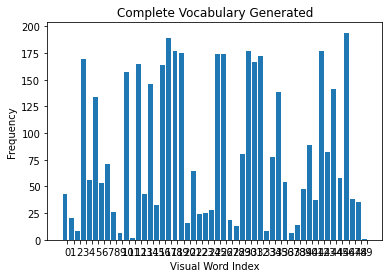

Features histogram plotted.
0.5 0.1
SVM fitted.
Training completed.
Training time:  320.2973756790161
Testing starting time:  Sun Apr 11 12:35:50 2021
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[18  1  7  2  1  0  1]
 [ 1 25  0  0  4  0  0]
 [ 3  3 21  1  0  0  2]
 [ 5  0  2 15  2  5  1]
 [ 4  1  0  4  7 14  0]
 [ 2  0  0  4  4 19  1]
 [ 2  1  7  0  2  0 17]]
Normalized confusion matrix
[[0.6  0.03 0.23 0.07 0.03 0.   0.03]
 [0.03 0.83 0.   0.   0.13 0.   0.  ]
 [0.1  0.1  0.7  0.03 0.   0.   0.07]
 [0.17 0.   0.07 0.5  0.07 0.17 0.03]
 [0.13 0.03 0.   0.13 0.23 0.47 0.  ]
 [0.07 0.   0.   0.13 0.13 0.63 0.03]
 [0.07 0.03 0.24 0.   0.07 0.   0.59]]


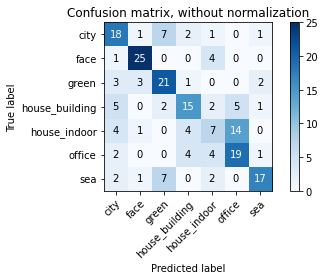

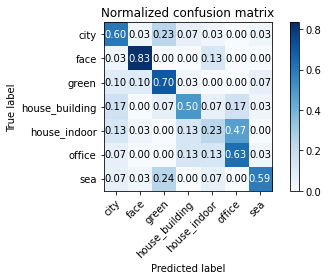

Confusion matrixes plotted.
accuracy score: 0.584
Accuracy calculated.
Execution done.
Testing time:  19.779767513275146


In [48]:
execute('./Dataset/train', './Dataset/test', 50, 'linear', 'sift')

##Confusion matrices for the Harris##

Training starting time:  Sun Apr 11 12:36:10 2021
Train images path detected.
Initialization skipped in train, Harris method.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


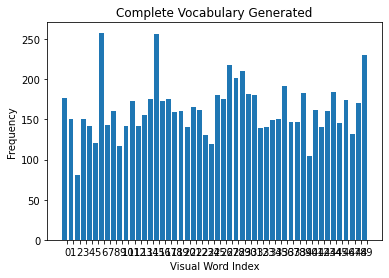

Features histogram plotted.
0.5 0.1
SVM fitted.
Training completed.
Training time:  37.53990197181702
Testing starting time:  Sun Apr 11 12:36:48 2021
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[15  2  3  0  2  1  7]
 [ 5 17  2  0  0  4  2]
 [ 5  2  6  4  3  3  7]
 [ 5  1  4 14  3  3  0]
 [ 9  0  2  5  6  5  3]
 [ 5  2  2  2  5 14  0]
 [ 6  4  5  1  3  1 10]]
Normalized confusion matrix
[[0.5  0.07 0.1  0.   0.07 0.03 0.23]
 [0.17 0.57 0.07 0.   0.   0.13 0.07]
 [0.17 0.07 0.2  0.13 0.1  0.1  0.23]
 [0.17 0.03 0.13 0.47 0.1  0.1  0.  ]
 [0.3  0.   0.07 0.17 0.2  0.17 0.1 ]
 [0.17 0.07 0.07 0.07 0.17 0.47 0.  ]
 [0.2  0.13 0.17 0.03 0.1  0.03 0.33]]


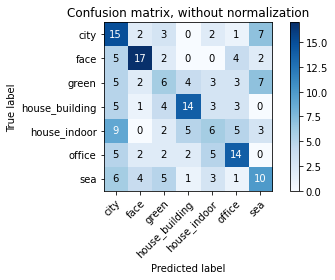

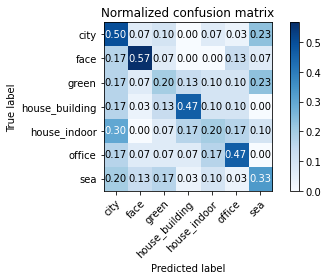

Confusion matrixes plotted.
accuracy score: 0.390
Accuracy calculated.
Execution done.
Testing time:  6.498961687088013


In [49]:
execute('./Dataset/train', './Dataset/test', 50, 'linear', 'harris')

##Confusion matrices for the BRISK##

Training starting time:  Sun Apr 11 12:36:54 2021
Train images path detected.
BRISK initialization in train.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


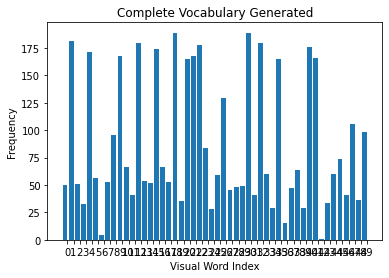

Features histogram plotted.
0.5 0.1
SVM fitted.
Training completed.
Training time:  469.95310735702515
Testing starting time:  Sun Apr 11 12:44:44 2021
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[16  0  5  4  0  1  4]
 [ 0 20  2  0  3  2  3]
 [ 3  2 14  2  0  2  7]
 [ 3  0  4 15  3  5  0]
 [ 2  1  5  4  4 13  1]
 [ 1  1  2  1  6 15  4]
 [ 1  1  7  0  0  3 18]]
Normalized confusion matrix
[[0.53 0.   0.17 0.13 0.   0.03 0.13]
 [0.   0.67 0.07 0.   0.1  0.07 0.1 ]
 [0.1  0.07 0.47 0.07 0.   0.07 0.23]
 [0.1  0.   0.13 0.5  0.1  0.17 0.  ]
 [0.07 0.03 0.17 0.13 0.13 0.43 0.03]
 [0.03 0.03 0.07 0.03 0.2  0.5  0.13]
 [0.03 0.03 0.23 0.   0.   0.1  0.6 ]]


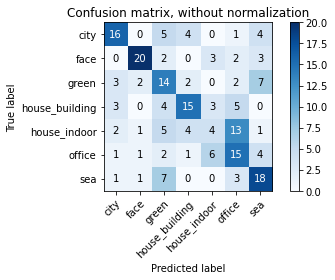

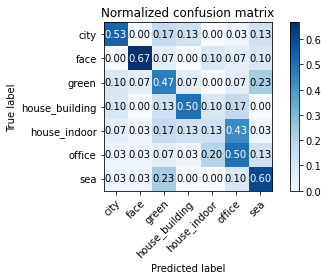

Confusion matrixes plotted.
accuracy score: 0.486
Accuracy calculated.
Execution done.
Testing time:  26.542168617248535


In [50]:
execute('./Dataset/train', './Dataset/test', 50, 'linear', 'brisk')

#**Show the extracted features using the three different methods on sample image from the dataset**#

##Sample random image from the dataset##

(1536, 2048, 3)
(150, 150)


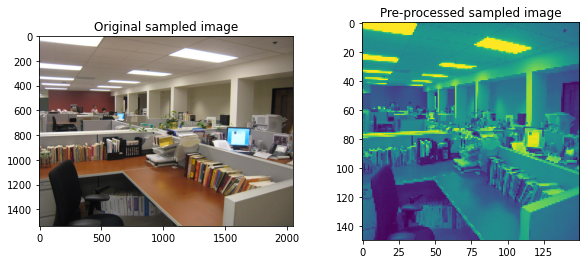

In [12]:
np.random.seed(1337)
all_data_dirlist = getFiles(True, './Dataset/train') 
sample_imgs_paths = np.random.choice(all_data_dirlist, 1)
for index, img_filename in enumerate(sample_imgs_paths):
  img_orig = Image.open(img_filename)
  img_resized = readImage(img_filename)
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
  ax1.imshow(img_orig)
  ax1.set_title("Original sampled image")
  print(np.array(img_orig).shape)
  ax2.imshow(img_resized)
  ax2.set_title("Pre-processed sampled image")
  print(np.array(img_resized).shape)

##Draw extracted features##

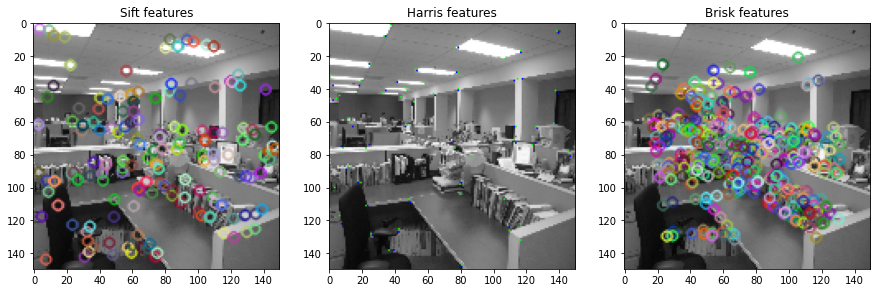

In [56]:
#draw SIFT features on the sampled image
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(img_resized, None)
sift_image = cv2.drawKeypoints(img_resized, kp, None)

#draw BRISK features on the sampled image
brisk = cv2.BRISK_create()
kp, des = brisk.detectAndCompute(img_resized, None)
brisk_image = cv2.drawKeypoints(img_resized, kp, None, flags=0)

#draw Harris corners on the sampled image
gray = img_resized.copy()
harris_img = cv2.cvtColor(np.array(gray),cv2.COLOR_GRAY2RGB)
centroids, corners = getCorners(gray)
res = np.hstack((centroids,corners))
res = np.int0(res)
harris_img[res[:,1],res[:,0]] = [0,0,255]
harris_img[res[:,3],res[:,2]] = [0,255,0]

f, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize=(15,15))
ax1.imshow(sift_image)
ax1.set_title("Sift features")
ax2.imshow(harris_img)
ax2.set_title('Harris features')
ax3.imshow(brisk_image)
ax3.set_title('Brisk features')
print("")
Image.fromarray(sift_image).save("sift.jpg")
Image.fromarray(harris_img).save("harris.jpg")
Image.fromarray(brisk_image).save("brisk.jpg")